<table class="tfo-notebook-buttons" align="left">
<td style="border: none;">
<a target="blank" href="https://colab.research.google.com/github/Hari31416/Portfolio/blob/main/ML/Housing_Price/Modeling.ipynb?hl=en"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" width="28" height="28"/>Run on Google Colab</a></td>
<td style="border: none;">
<a target="blank" href="https://github.com/Hari31416/Portfolio/blob/main/Housing_Price/ML/Modeling.ipynb"><img src="https://cdn.icon-icons.com/icons2/2368/PNG/512/github_logo_icon_143772.png" width="28" height="28"/>View on Github</a></td>
<td style="border: none;">
</table>

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Preprocessing

## Loading The Data

Let's start by loading the data.

In [3]:
X = pd.read_csv('data/train_final.csv')
test = pd.read_csv('data/test_final.csv')
y = pd.read_csv('data/y.csv')

Next step is to create the train and test sets as the data is already normalized.

## Making The Train and Test Sets

In [4]:
len(X)

1460

We see that we have just 1460 training examles. So, we should not be using a lot of examples for the test set. ABout 150 examples have to suffice.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
len(X_train), len(X_test)

(1314, 146)

# Modeling

## Creating Some Functions

In [19]:
def evaluate_model(y_true, y_pred = None, model=None, X_test=None):
    """
    Evaluates a model by computing the mean squared error and the r2 score.

    Parameters
    ----------
    y_true : pandas.Series
        The true values of the target variable.
    y_pred : pandas.Series
        The predicted values of the target variable.
        if None, the model is evaluated on the test set. `model` and `X_test` must be provided.
    model : sklearn.linear_model.LinearRegression
        The model to evaluate. Optional if `y_pred` is provided.
    X_test : pandas.DataFrame
        The test set. Optional if `y_pred` is provided.

    Returns
    -------
    rmse : float
        The root mean squared error.
    r2 : float
        The r2 score.
    ratio : float
        The ratio of the mean squared error to the mean value of the target variable.
    """
    rmse = mean_squared_error(y_true, y_pred)**0.5
    r_score = r2_score(y_true, y_pred)
    ratio = (rmse / y_true.mean()).values[0]
    result = {'rmse': rmse, 'r2': r_score, 'ratio': ratio}
    print('rmse:', rmse)
    print('R2:', r_score)
    print('Ratio:', ratio)
    return result

## The Base Model

Let's create a base model. We'll use a linear regression model with default parameters for this

In [8]:
lr_base = LinearRegression()
lr_base.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = lr_base.predict(X_test)
base_model_result = evaluate_model(y_test, y_pred)

rmse: 47435.83771241819
R2: 0.753721417512423
Ratio: 0.25939742165697893


In [21]:
y_pred = lr_base.predict(X_train)
evaluate_model(y_train, y_pred)

rmse: 38107.493570595456
R2: 0.7576423209884251
Ratio: 0.21088265173229595


{'rmse': 38107.493570595456,
 'r2': 0.7576423209884251,
 'ratio': 0.21088265173229595}

Now, as our base model is here, we can start experimenting.

## Polynomial Model

Let's fit a polynomial model of order 2 on the training data.

In [38]:
pf = PolynomialFeatures(degree=2)
X_train_pf = pf.fit_transform(X_train)
X_test_pf = pf.fit_transform(X_test)

In [42]:
lr_pf = LinearRegression()
lr_pf.fit(X_train_pf, y_train)


LinearRegression()

In [43]:
y_pred = lr_pf.predict(X_test_pf)
poly_reg_result =  evaluate_model(y_test, y_pred)

rmse: 68232.86347065943
R2: 0.4904337089356018
Ratio: 0.37312356458982066


In [44]:
y_pred = lr_pf.predict(X_test_pf)
y_pred = np.abs(y_pred)
poly_reg_result =  evaluate_model(y_test, y_pred)

rmse: 56795.40174109139
R2: 0.646947047454522
Ratio: 0.31057912085221945


It is performing worse than the base model. What's more, sometimes, the model in return negative values for the predictions.

In [46]:
evaluate_model(y_train, lr_pf.predict(X_train_pf))

rmse: 161.90692028798085
R2: 0.9999956251130148
Ratio: 0.0008959749772282216


{'rmse': 161.90692028798085,
 'r2': 0.9999956251130148,
 'ratio': 0.0008959749772282216}

So this is why the model is perfoming this terribly on test set. The model is overfitting quite severely. Let's try some regularization techniques and grid search to find the best parameters.

#### First Iteration

In [ ]:
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100], "l1_ratio": [0.1,0.3, 0.5, 0.7, 0.9]}
base_model = ElasticNet(random_state=42, max_iter=10000)
grid_model = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose =1)
grid_model.fit(X_train_pf, y_train)

In [54]:
grid_model.best_params_

{'alpha': 1, 'l1_ratio': 0.5}

#### Second Iteration

In [55]:
param_grid = {"alpha": [0.8, 1, 2, 5], "l1_ratio": [0.4, 0.5, 0.6,]}
base_model = ElasticNet(random_state=42, max_iter=10000)
grid_model = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=ElasticNet(max_iter=10000, random_state=42),
             param_grid={'alpha': [0.8, 1, 2, 5], 'l1_ratio': [0.4, 0.5, 0.6]},
             scoring='neg_mean_squared_error')

In [56]:
grid_model.best_params_

{'alpha': 0.8, 'l1_ratio': 0.5}

#### Third Iteration

In [59]:
param_grid = {"alpha": [0.6, 0.7, 0.8, 0.9], "l1_ratio": [0.45, 0.5, 0.55,]}
base_model = ElasticNet(random_state=42, max_iter=10000)
grid_model = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=ElasticNet(max_iter=10000, random_state=42),
             param_grid={'alpha': [0.6, 0.7, 0.8, 0.9],
                         'l1_ratio': [0.45, 0.5, 0.55]},
             scoring='neg_mean_squared_error')

In [60]:
grid_model.best_params_

{'alpha': 0.8, 'l1_ratio': 0.45}

This is the final parameters that we have selected.

In [61]:
el_net_best_model = grid_model.best_estimator_
el_net_best_model.fit(X_train, y_train)

ElasticNet(alpha=0.8, l1_ratio=0.45, max_iter=10000, random_state=42)

In [ ]:
y_pred = el_net_best_model.predict(X_test_pf)
evaluate_model(y_test, y_pred)

In [50]:
evaluate_model(y_train, el_net_best_model.predict(X_train_pf))

rmse: 9501.954771838984
R2: 0.9849317806911022
Ratio: 0.05258276604347236


{'rmse': 9501.954771838984,
 'r2': 0.9849317806911022,
 'ratio': 0.05258276604347236}

### Neural Network

In [32]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

In [40]:
model = Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                6144      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [56]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X, y, epochs=100, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 3s 20ms/step - loss: 1200752512.0000 - mae: 22975.6738 - val_loss: 2534296320.0000 - val_mae: 19430.7891
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 1067497152.0000 - mae: 21547.6836 - val_loss: 2481639936.0000 - val_mae: 19285.6816
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 1147287296.0000 - mae: 22612.2773 - val_loss: 2558787840.0000 - val_mae: 20035.2949
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 1115879168.0000 - mae: 21925.0098 - val_loss: 2566669568.0000 - val_mae: 20472.4727
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 949824704.0000 - mae: 21706.7441 - val_loss: 2530386944.0000 - val_mae: 19196.4980
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 1008728064.0000 - mae: 21786.8457 - val_loss: 2558280704.0000 - val_mae: 21061.6523
Epoch 7/100
37/37 [==============================] - 0s 5m

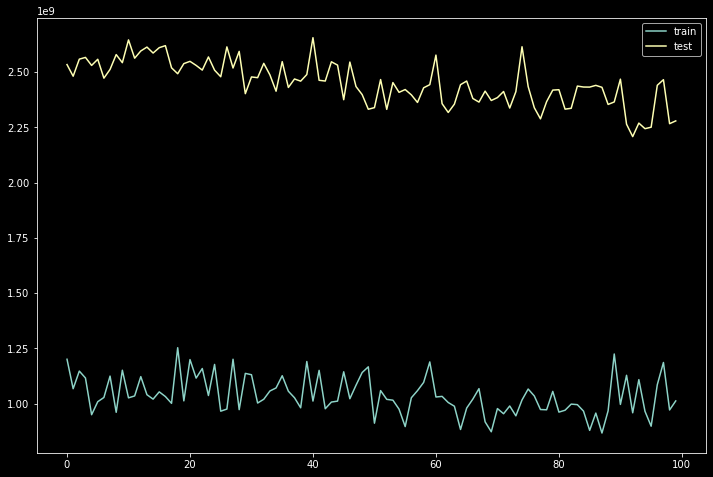

In [57]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [58]:
pred = model.predict(test)
label = pd.read_csv('data/test_Id.csv')
assert len(pred) == len(label)
sub = pd.DataFrame(label["Id"], columns=["Id"])
sub["SalePrice"] = pred
sub.to_csv('data\submissions\submission_2.csv', index=False)

In [59]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f data\submissions\submission_2.csv -m "Second submission"

Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/22.6k [00:00<?, ?B/s]
 35%|███▌      | 8.00k/22.6k [00:00<00:00, 69.7kB/s]
100%|██████████| 22.6k/22.6k [00:05<00:00, 4.08kB/s]
